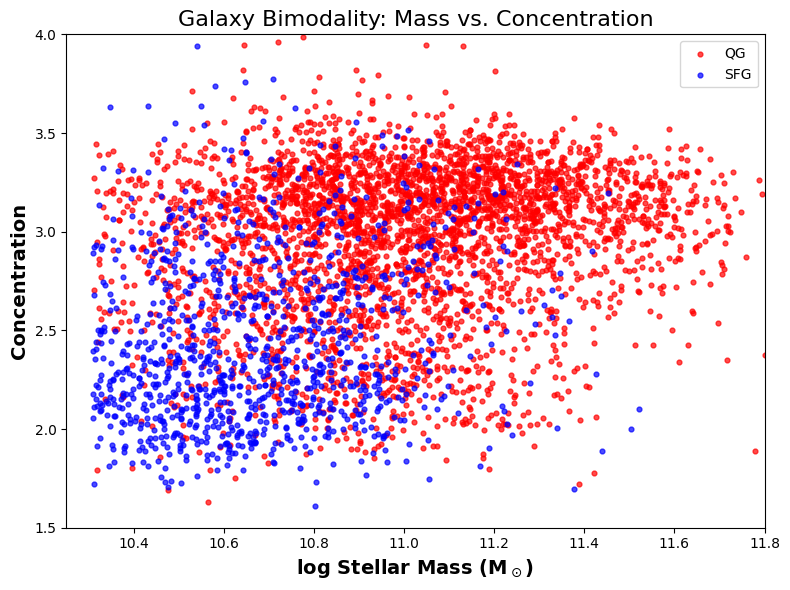

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = pd.read_csv('LBAT6-datatable-N4514.csv')

# Compute u-r and r-z colors
data['u_r'] = data['uMag_o'] - data['rMag_o']
data['r_z'] = data['rMag_o'] - data['zMag_o']

# Define QG/SFG by Holden+12 urz cuts
mask_low_rz = data['r_z'] < 0.75
mask_high_rz = ~mask_low_rz
qg_mask = ((mask_low_rz) & (data['u_r'] > 2.26)) | ((mask_high_rz) & (data['u_r'] > 0.76 + 2*data['r_z']))
data['type'] = np.where(qg_mask, 'QG', 'SFG')




# Plot
plt.figure(figsize=(8,6))
for t, color in zip(['QG','SFG'], ['red','blue']):
    sub = data[data['type']==t]
    plt.scatter(sub['logMsuns_p'], sub['rConc_o'], s=12, alpha=0.7, label=t, color=color)
plt.xlabel('log Stellar Mass (M$_\odot$)', fontsize=14, fontweight='bold')
plt.ylabel('Concentration', fontsize=14, fontweight='bold')
plt.title('Galaxy Bimodality: Mass vs. Concentration', fontsize=16)
plt.legend()
plt.xlim(10.25, 11.8)       # Adjust based on logMsuns_p range
plt.ylim(1.5, 4.)        # Adjust based on rConc_o range
plt.tight_layout()
plt.show()

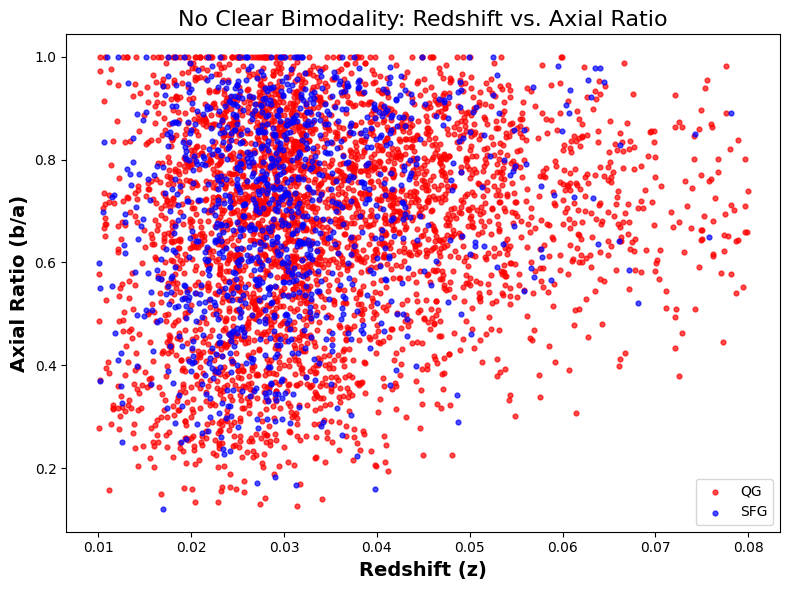

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data & type flag (as above)
data = pd.read_csv('LBAT6-datatable-N4514.csv')
data['u_r'] = data['uMag_o'] - data['rMag_o']
data['r_z'] = data['rMag_o'] - data['zMag_o']
mask_low_rz = data['r_z'] < 0.75
mask_high_rz = ~mask_low_rz
qg_mask = ((mask_low_rz) & (data['u_r'] > 2.26)) | ((mask_high_rz) & (data['u_r'] > 0.76 + 2*data['r_z']))
data['type'] = np.where(qg_mask, 'QG', 'SFG')

# Plot
plt.figure(figsize=(8,6))
for t, color in zip(['QG','SFG'], ['red','blue']):
    sub = data[data['type']==t]
    plt.scatter(sub['z_o'], sub['r_isoBA_o'], s=12, alpha=0.7, label=t, color=color)
plt.xlabel('Redshift (z)', fontsize=14, fontweight='bold')
plt.ylabel('Axial Ratio (b/a)', fontsize=14, fontweight='bold')
plt.title('No Clear Bimodality: Redshift vs. Axial Ratio', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


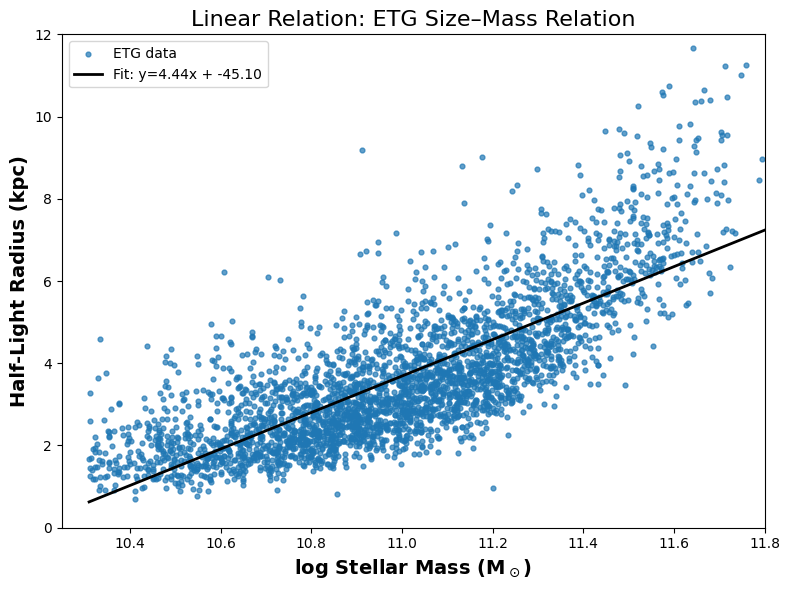

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load data & compute concentration
data = pd.read_csv('LBAT6-datatable-N4514.csv')
# concentration in r-band:
conc = data['rConc_o']

# Select ETGs by concentration threshold (e.g. >2.6)
etg = data[conc > 2.6]
x = etg['logMsuns_p']
y = etg['rR50_p']  # half-light radius in kpc

# Fit
slope, intercept, r_val, p_val, std_err = linregress(x, y)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, s=12, alpha=0.7, label='ETG data')
x_line = np.linspace(x.min(), x.max(), 100)
plt.plot(x_line, slope*x_line + intercept, color='black', lw=2,
         label=f'Fit: y={slope:.2f}x + {intercept:.2f}')
plt.xlabel('log Stellar Mass (M$_\odot$)', fontsize=14, fontweight='bold')
plt.ylabel('Half-Light Radius (kpc)', fontsize=14, fontweight='bold')
plt.title('Linear Relation: ETG Size–Mass Relation', fontsize=16)
plt.legend()
plt.xlim(10.25, 11.8)       # Adjust based on logMsuns_p range
plt.ylim(0, 12)
plt.tight_layout()
plt.show()

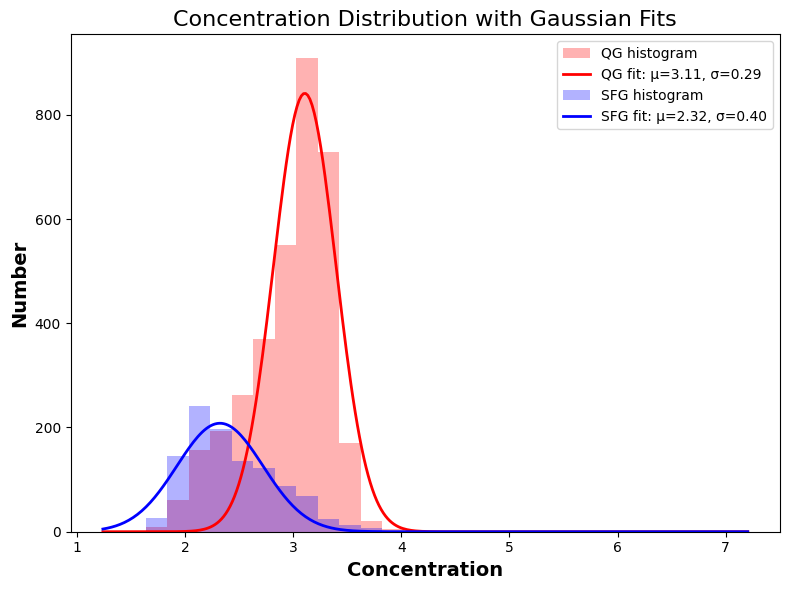

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# Load data & type flag
data = pd.read_csv('LBAT6-datatable-N4514.csv')
data['u_r'] = data['uMag_o'] - data['rMag_o']
data['r_z'] = data['rMag_o'] - data['zMag_o']
mask_low_rz = data['r_z'] < 0.75
mask_high_rz = ~mask_low_rz
qg_mask = ((mask_low_rz) & (data['u_r'] > 2.26)) | ((mask_high_rz) & (data['u_r'] > 0.76 + 2*data['r_z']))
data['type'] = np.where(qg_mask, 'QG', 'SFG')

# Helper Gaussian
def gauss(x, mu, sigma, A, N, w):
    return A * norm.pdf(x, mu, sigma) * N * w

# Plot
plt.figure(figsize=(8,6))
bins = 30

# Define common bin edges based on combined data
all_vals = data['rConc_o']
bin_edges = np.histogram_bin_edges(all_vals, bins=bins)

for t, color in zip(['QG','SFG'], ['red','blue']):
    vals = data[data['type']==t]['rConc_o']
    counts, _ = np.histogram(vals, bins=bin_edges, density=False)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    w = bin_edges[1] - bin_edges[0]
    N = len(vals)

    # Plot histogram with common bins
    plt.hist(vals, bins=bin_edges, alpha=0.3, label=f'{t} histogram', color=color)

    # Fit
    p0 = [vals.mean(), vals.std(), counts.max()]
    popt, _ = curve_fit(lambda x, mu, sigma, A: gauss(x, mu, sigma, A, N, w),
                        centers, counts, p0=p0)
    x_fit = np.linspace(bin_edges.min(), bin_edges.max(), 300)
    y_fit = gauss(x_fit, *popt, N=N, w=w)
    plt.plot(x_fit, y_fit, color=color, lw=2,
             label=f'{t} fit: μ={popt[0]:.2f}, σ={popt[1]:.2f}')

plt.xlabel('Concentration', fontsize=14, fontweight='bold')
plt.ylabel('Number', fontsize=14, fontweight='bold')
plt.title('Concentration Distribution with Gaussian Fits', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load your CSV file
data = pd.read_csv('LBAT6-datatable-N4514.csv')

# Compute colors for classification
data['u_r'] = data['uMag_o'] - data['rMag_o']
data['r_z'] = data['rMag_o'] - data['zMag_o']

# Classify into QG and SFG using the urz selection
mask_low_rz = data['r_z'] < 0.75
mask_high_rz = ~mask_low_rz
qg_mask = ((mask_low_rz) & (data['u_r'] > 2.26)) | ((mask_high_rz) & (data['u_r'] > 0.76 + 2 * data['r_z']))
data['type'] = np.where(qg_mask, 'QG', 'SFG')

# Compute means of each group
means = data.groupby('type')[['logMsuns_p', 'rConc_o']].mean()

# Define how many representative galaxies you want
n_representatives = 5

# Function to return the most representative galaxies for a given type
def find_representatives(df, pop_type, n=5):
    mean_mass = means.loc[pop_type, 'logMsuns_p']
    mean_conc = means.loc[pop_type, 'rConc_o']
    group = df[df['type'] == pop_type].copy()
    group['dist'] = np.sqrt((group['logMsuns_p'] - mean_mass)**2 + (group['rConc_o'] - mean_conc)**2)
    return group.nsmallest(n, 'dist')[['ID', 'logMsuns_p', 'rConc_o', 'u_r', 'type']]

# Output results
qg_reps = find_representatives(data, 'QG', n=n_representatives)
sfg_reps = find_representatives(data, 'SFG', n=n_representatives)

print("Top QG Representatives:")
print(qg_reps.to_string(index=False))
print("\nTop SFG Representatives:")
print(sfg_reps.to_string(index=False))

Top QG Representatives:
       ID  logMsuns_p  rConc_o      u_r type
nyu581190      11.011    2.960 2.529467   QG
nyu177902      11.009    2.958 2.527825   QG
nyu137327      10.995    2.977 2.764857   QG
nyu242532      11.010    2.984 2.619113   QG
nyu283474      11.031    2.953 2.644286   QG

Top SFG Representatives:
       ID  logMsuns_p  rConc_o      u_r type
nyu407104      10.696    2.421 2.222062  SFG
nyu688689      10.668    2.458 2.246397  SFG
nyu312245      10.703    2.461 2.238023  SFG
nyu770938      10.693    2.409 2.230579  SFG
nyu353141      10.654    2.428 2.142798  SFG


In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file
data = pd.read_csv('LBAT6-datatable-N4514.csv')

# Compute colors for classification
data['u_r'] = data['uMag_o'] - data['rMag_o']
data['r_z'] = data['rMag_o'] - data['zMag_o']

# Define QG vs SFG
mask_low_rz = data['r_z'] < 0.75
mask_high_rz = ~mask_low_rz
qg_mask = ((mask_low_rz) & (data['u_r'] > 2.26)) | ((mask_high_rz) & (data['u_r'] > 0.76 + 2 * data['r_z']))
data['type'] = np.where(qg_mask, 'QG', 'SFG')

# Compute group means
means = data.groupby('type')[['logMsuns_p', 'rConc_o']].mean()

# Set number of galaxies to return per type
n_representatives = 5

# Function to find representative galaxies
def find_representatives(df, pop_type, n=5):
    mean_mass = means.loc[pop_type, 'logMsuns_p']
    mean_conc = means.loc[pop_type, 'rConc_o']
    group = df[df['type'] == pop_type].copy()
    group['dist'] = np.sqrt((group['logMsuns_p'] - mean_mass)**2 + (group['rConc_o'] - mean_conc)**2)
    return group.nsmallest(n, 'dist')[['ID', 'RA_o', 'Dec_o']]

# Get top representatives
qg_reps = find_representatives(data, 'QG', n=n_representatives)
sfg_reps = find_representatives(data, 'SFG', n=n_representatives)

# Output
print("Top QG Representatives (ID, RA, Dec):")
print(qg_reps.to_string(index=False))
print("\nTop SFG Representatives (ID, RA, Dec):")
print(sfg_reps.to_string(index=False))

Top QG Representatives (ID, RA, Dec):
       ID       RA_o     Dec_o
nyu581190 118.032639 27.483907
nyu177902 263.050816 59.941598
nyu137327 134.799667 54.043139
nyu242532  61.230088 -6.304820
nyu283474 157.358311 60.295648

Top SFG Representatives (ID, RA, Dec):
       ID       RA_o     Dec_o
nyu407104 247.907976 41.493643
nyu688689 244.005632 37.918652
nyu312245 155.601715  3.997349
nyu770938 130.852981  8.079689
nyu353141 216.474050  4.642701
